### Robot Sense and Motion

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import Image
from robot_class import Robot
from helper import save_display_world

%matplotlib inline

In [43]:
# Dummy set up
world_size         = 10.0    # size of world (square)
measurement_range  = 3.0     # range at which we can sense landmarks
motion_noise       = 0.2      # noise in robot motion
measurement_noise  = 0.2      # noise in the measurements

# instantiate a robot, r
r = Robot(world_size, measurement_range, motion_noise, measurement_noise)

# print out the location of r
print(r)

Robot: [x=5.00000 y=5.00000]


Robot: [x=5.00000 y=5.00000]


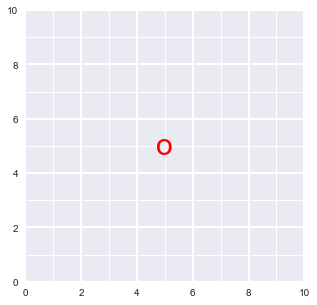

In [44]:
from helper import display_world
plt.rcParams["figure.figsize"] = (5,5)
print(r)
display_world(int(world_size), [r.x, r.y])

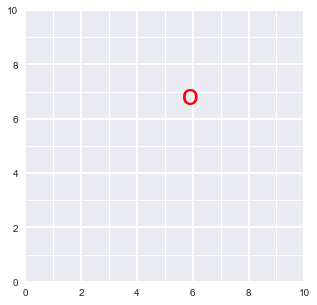

In [45]:
r.move(1,2)
display_world(int(world_size), [r.x, r.y])

In [46]:
print(r)

Robot: [x=5.91645 y=6.83202]


In [47]:
num_landmarks = 5
r.make_landmarks(num_landmarks)

print(r)

Robot: [x=5.91645 y=6.83202]


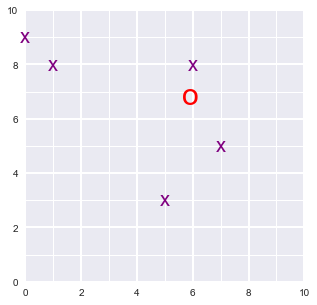

Landmark Location [x,y]:  [[1, 8], [7, 5], [0, 9], [6, 8], [5, 3]]


In [48]:
display_world(int(world_size), [r.x, r.y], r.landmarks)

print("Landmark Location [x,y]: ", r.landmarks)

In [49]:
measurements = r.sense()
print(measurements)

[[0, -4.857654449980791, 1.2453954365911428], [1, 1.025190557527567, -1.749166423869857], [2, -6.012819104517257, 2.162851415139234], [3, 0.009431259184084731, 1.155950514048884], [4, -1.0738199294613984, -3.648596047929279]]


## SLAM - [Simultaneous Localization And Mapping](https://en.wikipedia.org/wiki/Simultaneous_localization_and_mapping)

*As stated in Wikipedia, SLAM is the computational problem of constructing or updating a map of an unknown environment while simultaneously keeping track of an agent's location within it.*

Now, the agent here is the 'O'. With help of measurement and motion updates the 'O' tries to develop the map as it navigates. There are different techniques in constructing the map from these updates and one such technique is GraphSLAM.

### Omega and Xi

To implement Graph SLAM, a matrix and a vector (omega and xi, respectively) are introduced. The matrix is square and labelled with all the robot poses (xi) and all the landmarks (Li). Every time you make an observation, for example, as you move between two poses by some distance dx and can relate those two positions, you can represent this as a numerical relationship in these matrices.

It's easiest to see how these work in an example. Below you can see a matrix representation of omega and a vector representation of xi.

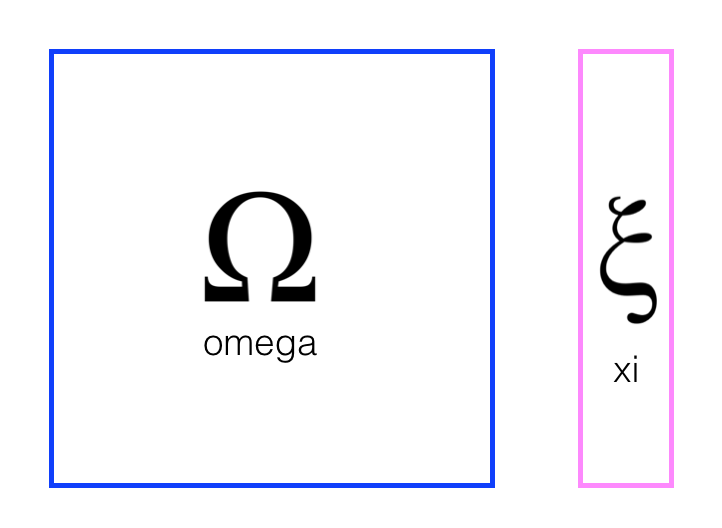

In [50]:
Image('omega_xi.png')

Next, let's look at a simple example that relates 3 poses to one another.

* When you start out in the world most of these values are zeros or contain only values from the initial robot position
* In this example, you have been given constraints, which relate these poses to one another
* Constraints translate into matrix values

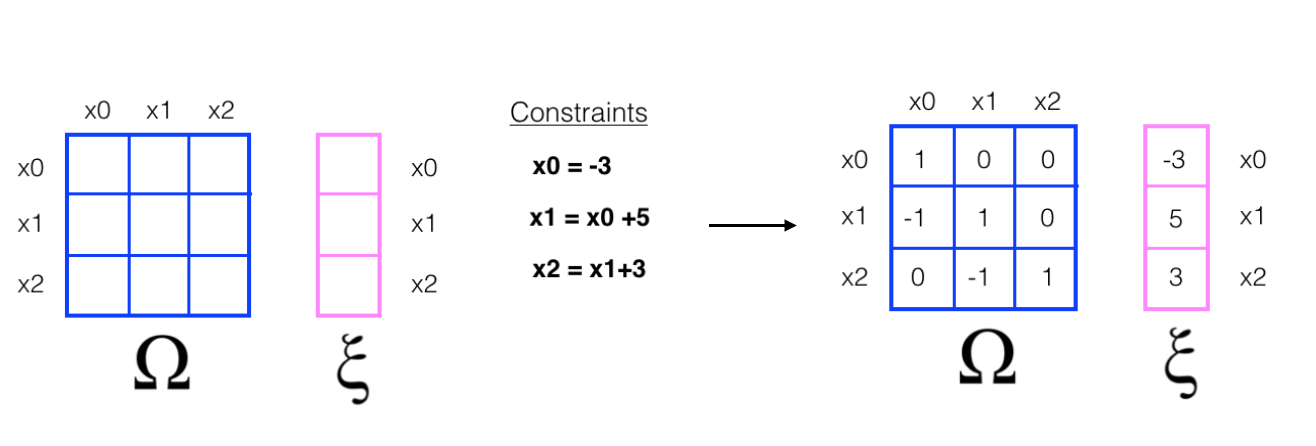

In [51]:
Image('omega_xi_constraints.png')

The above matrix and vector combination looks like system of linear equation. We solve it as below

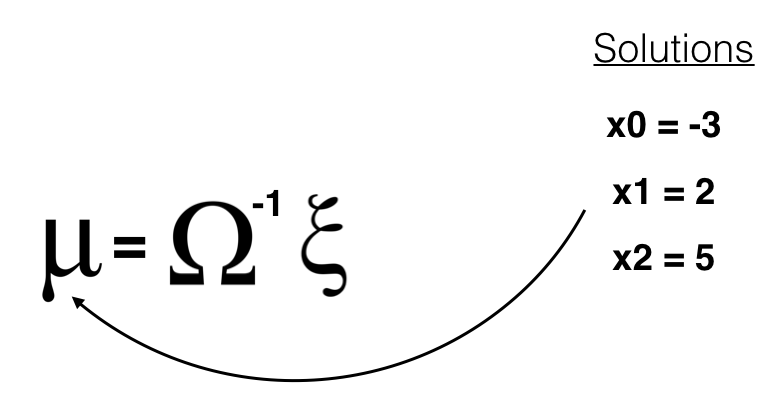

In [52]:
Image('solution.png')

In [53]:
#dummy system of equations
# define omega and xi as in the example
omega = np.array([[1,0,0],
                  [-1,1,0],
                  [0,-1,1]])

xi = np.array([[-3],
               [5],
               [3]])

# calculate the inverse of omega
omega_inv = np.linalg.inv(np.matrix(omega))

# calculate the solution, mu
mu = omega_inv*xi

# print out the values of mu (x0, x1, x2)
print(mu)

[[-3.]
 [ 2.]
 [ 5.]]


### Motion Constraints and Landmarks

In the last example, the constraint equations, relating one pose to another were given to you. In this next example, let's look at how motion (and similarly, sensor measurements) can be used to create constraints and fill up the constraint matrices, omega and xi. Let's start with empty/zero matrices.

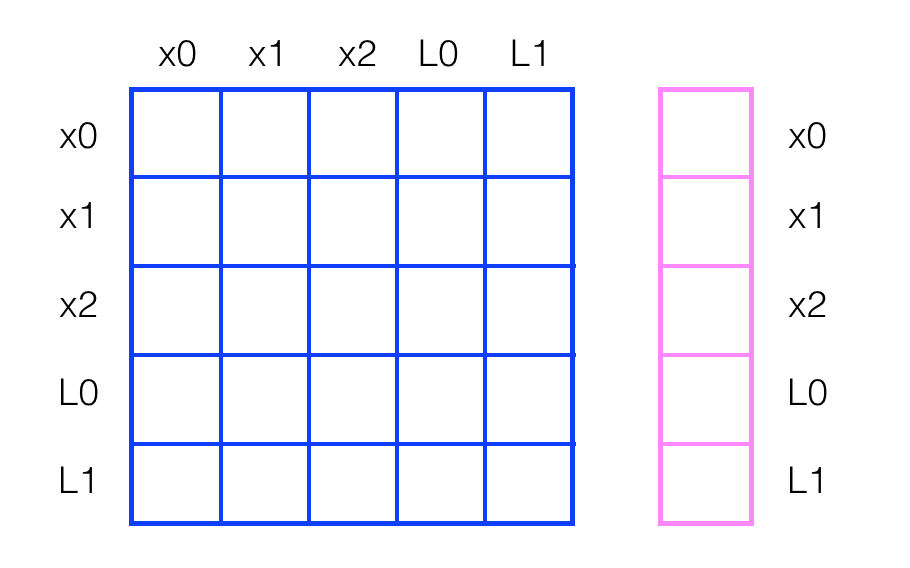

In [54]:
Image("initial_constraints.png")

This example also includes relationships between poses and landmarks. Say we move from x0 to x1 with a displacement dx of 5. Then we have created a motion constraint that relates x0 to x1, and we can start to fill up these matrices.

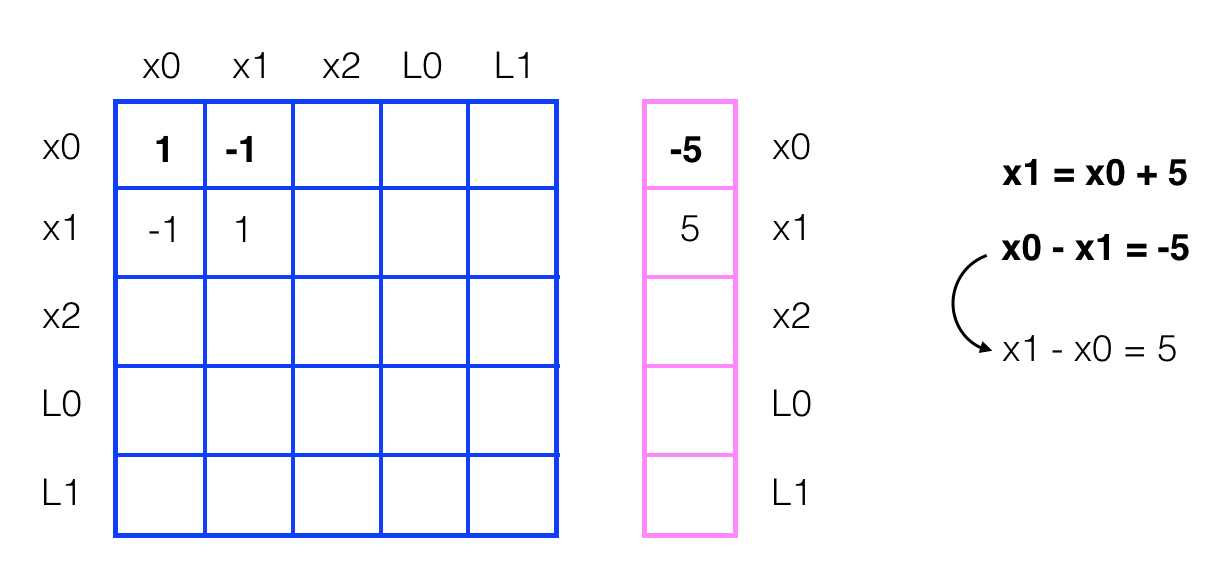

In [55]:
Image("motion_constraint.png")

In fact, the one constraint equation can be written in two ways. So, the motion constraint that relates x0 and x1 by the motion of 5 has affected the matrix, adding values for all elements that correspond to x0 and x1.

### SLAM Implementation

Implementing SLAM for robot that moves and senses in a 2 dimensional, grid world!

SLAM gives us a way to both localize a robot and build up a map of its environment as a robot moves and senses in real-time. This is an active area of research in the fields of robotics and autonomous systems. Since this localization and map-building relies on the visual sensing of landmarks, this is a computer vision problem.

From robot motion, representations of uncertainty in motion and sensing, and localization techniques, we define a function, slam, which takes in six parameters as input and returns the vector mu.

   * mu contains the (x,y) coordinate locations of the robot as it moves, and the positions of landmarks that it senses in the world
   
The vector, mu, should have (x, y) coordinates interlaced, for example, if there were 2 poses and 2 landmarks, mu will look like the following, where P is the robot position and L the landmark position:

                                    mu =  matrix([[Px0],
                                                  [Py0],             
                                                  [Px1],
                                                  [Py1],
                                                  [Lx0],
                                                  [Ly0],
                                                  [Lx1],
                                                  [Ly1]])
              
              
You can see that mu holds the poses first (x0, y0), (x1, y1), ..., then the landmark locations at the end of the matrix; we consider a nx1 matrix to be a vector.

### Generate Environment for Point to Move

In a real SLAM problem, we may be given a map that contains information about landmark locations, and in this example, we will make our own data using the make_data function, which generates a world grid with landmarks in it and then generates data by placing a robot in that world and moving and sensing over some numer of time steps. The make_data function relies on a correct implementation of robot move/sense functions, which present in robot_class.py file. The data is collected as an instantiated robot moves and senses in a world. Your SLAM function will take in this data as input. So, let's first create this data and explore how it represents the movement and sensor measurements that our robot takes.


### Create World

In [56]:
from helper import make_data

num_landmarks = 5
N = 20
world_grid = 100

measurement_range = 50.0
measurement_noise = 2.0
motion_noise = 2.0
distance = 20.0

data = make_data(N, num_landmarks, world_grid, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[37, 58], [80, 93], [99, 73], [77, 58], [34, 78]]
Robot: [x=24.15875 y=31.44479]


The function above, make_data, takes in so many world and robot motion/sensor parameters because it is responsible for:

* Instantiating a robot (using the robot class)
* Creating a grid world with landmarks in it

This function also prints out the true location of landmarks and the final robot location, the final location is helpful for testing the implementation of SLAM.

The data this returns is an array that holds information about robot sensor measurements and robot motion (dx, dy) that is collected over a number of time steps, N. You will have to use only these readings about motion and measurements to track a robot over time and find the determine the location of the landmarks using SLAM. We only print out the true landmark locations for comparison, later.

In data the measurement and motion data can be accessed from the first and second index in the columns of the data array. See the following code for an example, where i is the time step:
   * measurement = data[i][0]
   * motion = data[i][1]

In [57]:
# print out some stats about the data
time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, -12.944989853354112, 7.272243519268541], [1, 30.959755358912666, 42.23526273603368], [2, 48.78393893025296, 23.50560507098843], [3, 25.922105835985565, 6.830605345509819], [4, -17.7453032743712, 27.865675934253947]]


Example motion: 
 [19.78241139604634, 2.942141967610673]


Try changing the value of time_step, we should see that the list of measurements varies based on what in the world the robot sees after it moves. As you know from the sense and move, the robot can only sense so far and with a certain amount of accuracy in the measure of distance between its location and the location of landmarks. The motion of the robot always is a vector with two values: one for x and one for y displacement. This structure will be useful to keep in mind as we traverse this data in your implementation of slam.


### Initial Constraints

One of the most challenging tasks here will be to create and modify the constraint matrix and vector: omega and xi. Omega and Xi holds all the values that defines the relationships between robot poses xi and landmark positions Li in a 1D world.

In this project, we are tasked with implementing constraints for a 2D world. We are referring to robot poses as Px, Py and landmark positions as Lx, Ly, and one way to approach this challenge is to add both x and y locations in the constraint matrices.


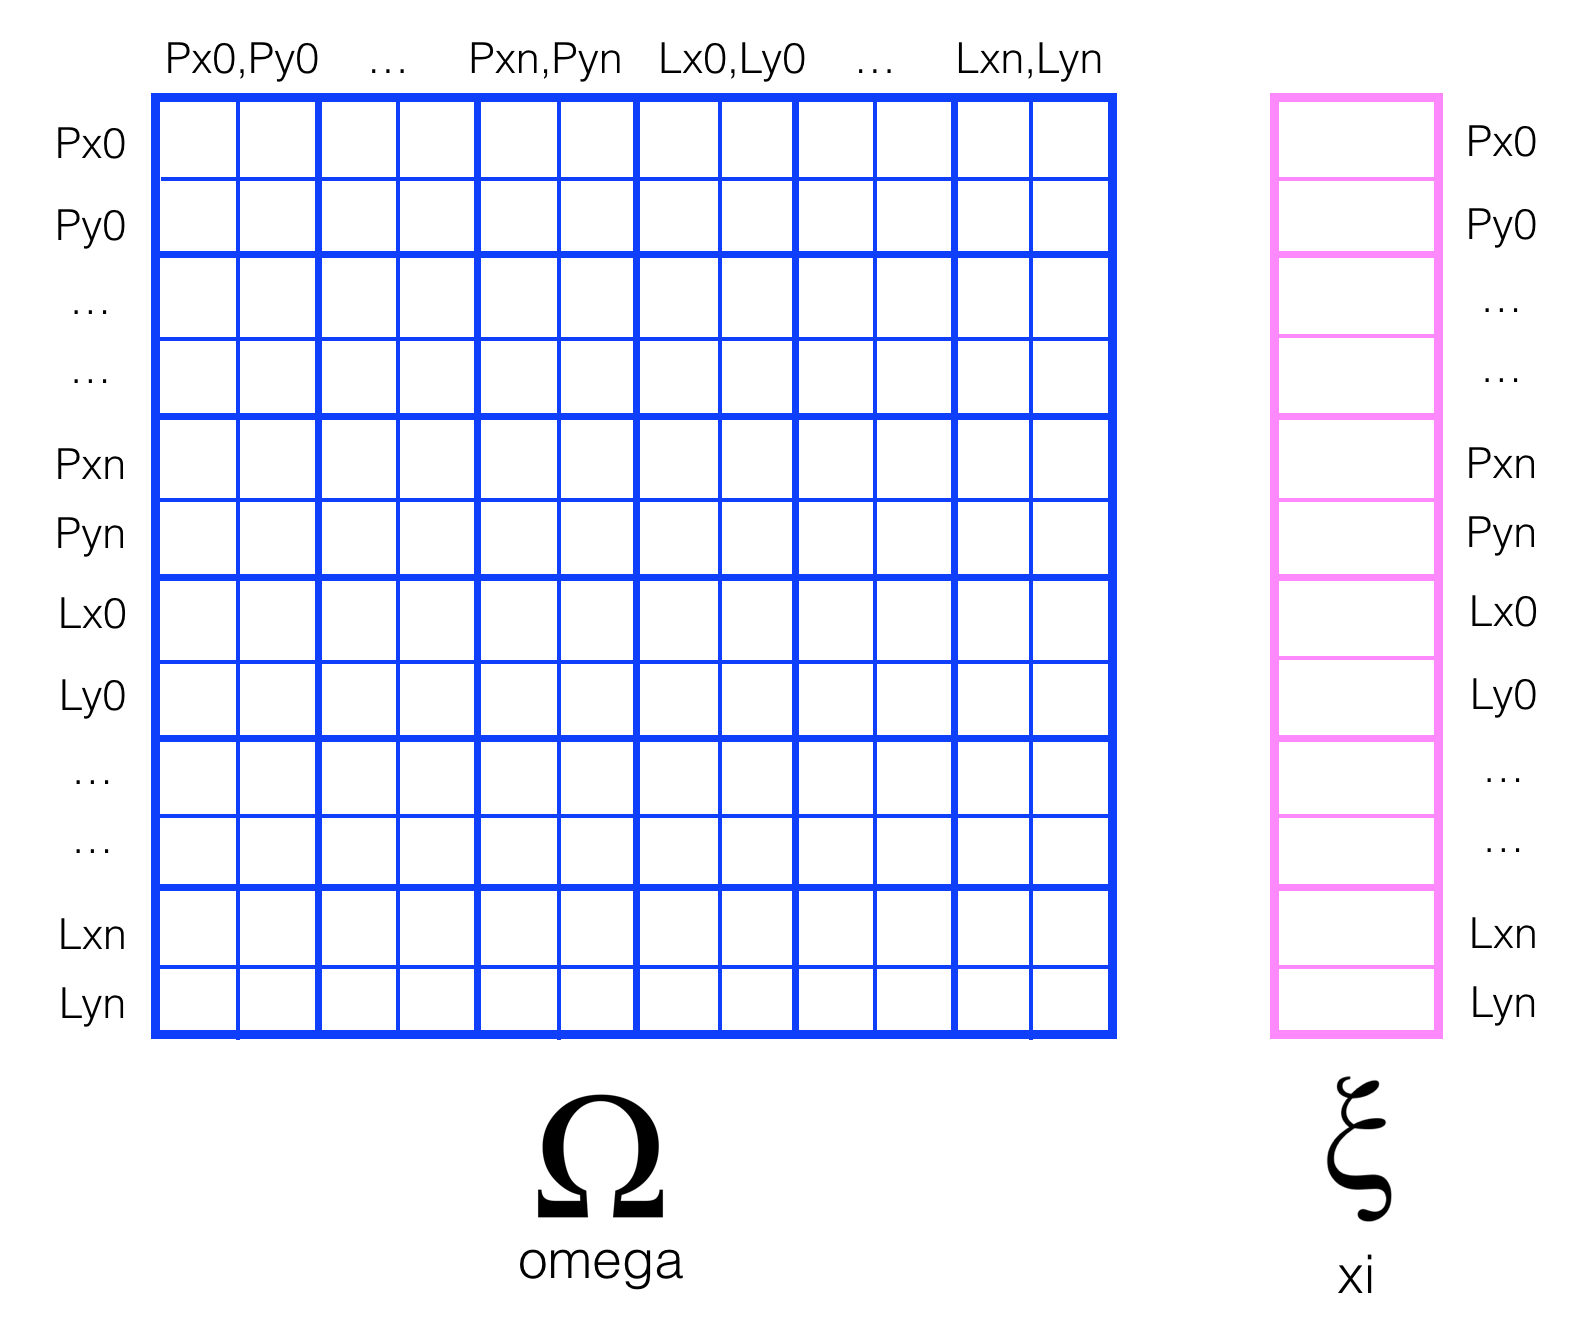

In [58]:
Image('constraints2D.png')

In [59]:
def initialize_constraints(N, num_landmarks, world_grid):
    rows = N*2 + num_landmarks*2
    cols = N*2 + num_landmarks*2
    print(rows)
    Omega = np.zeros((rows, cols))
    Omega[0][0] = 1
    Omega[1][1] = 1
    
    Xi = np.zeros((rows, 1))
    Xi[0][0] = world_grid/2.0
    Xi[1][0] = world_grid/2.0
    
    return Omega, Xi

### Test as you go

It's good practice to test out the code, as we proceed. Since slam relies on creating and updating constraint matrices, omega and xi to account for robot sensor measurements and motion, let's check that they initialize as expected for any given parameters.

Below, you'll find some test code that allows you to visualize the results of your function initialize_constraints. We are using the seaborn library for visualization.

Please change the test values of N, landmarks, and world_size and see the results. Be careful not to use these values as input into your final slam function.

This code assumes that you have created one of each constraint: omega and xi, but you can change and add to this code, accordingly. The constraints should vary in size with the number of time steps and landmarks as these values affect the number of poses a robot will take (Px0,Py0,...Pxn,Pyn) and landmark locations (Lx0,Ly0,...Lxn,Lyn) whose relationships should be tracked in the constraint matrices. Recall that omega holds the weights of each variable and xi holds the value of the sum of these variables. You'll need the world_size to determine the starting pose of the robot in the world and fill in the initial values for xi.

In [60]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

In [61]:
# define a small N and world_size (small for ease of visualization)
N_test = 5
num_landmarks_test = 2
small_world = 10

# initialize the constraints
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

14


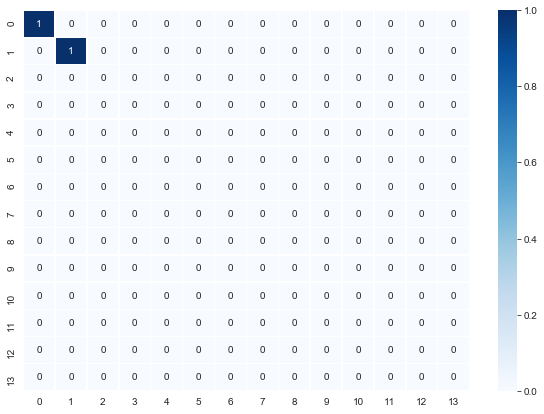

In [62]:
# define figure size
plt.rcParams["figure.figsize"] = (10,7)

# display omega
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

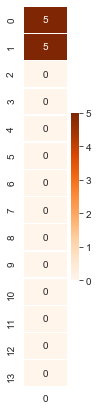

In [63]:
# define  figure size
plt.rcParams["figure.figsize"] = (1,7)

# display xi
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

### Note

The initial Omega heatmap refers to initialization of (x,y), also known as **pose**, which is at (5,5) as mentioned in Xi initialization. Since we are initialization the position of robot, we have absolute certainty of its position and initialize it as (1,1).

### SLAM Function

#### SLAM inputs

In addition to data, slam function takes in:

* N - The number of time steps that a robot will be moving and sensing
* num_landmarks - The number of landmarks in the world
* world_size - The size (w/h) of your world
* motion_noise - The noise associated with motion; the update confidence for motion should be 1.0/motion_noise
* measurement_noise - The noise associated with measurement/sensing; the update weight for measurement should be 1.0/measurement_noise

#### Noise

Recall that omega holds the relative "strengths" or weights for each position variable, and you can update these weights by accessing the correct index in omega omega[row][col] and adding/subtracting 1.0/noise where noise is measurement or motion noise. Xi holds actual position values, and so to update xi you'll do a similar addition process only using the actual value of a motion or measurement. So for a vector index xi[row][0] you will end up adding/subtracting one measurement or motion divided by their respective noise.

#### Updating with motion and measurements

With a 2D omega and xi structure as shown above (in earlier cells), you'll have to be mindful about how you update the values in these constraint matrices to account for motion and measurement constraints in the x and y directions. Recall that the solution to these matrices (which holds all values for robot poses P and landmark locations L) is the vector, mu, which can be computed at the end of the construction of omega and xi as the inverse of omega times xi: $\mu = \Omega^{-1}\xi$


In [64]:
## slam takes in 6 arguments and returns mu, 
## mu is the entire path traversed by a robot (all x,y poses) *and* all landmarks locations
def slam(data, N, num_landmarks, world_grid, motion_noise, measurement_noise):
    
    ## TODO: Use your initilization to create constraint matrices, omega and xi
    omega, xi = initialize_constraints(N, num_landmarks, world_grid)
    ## TODO: Iterate through each time step in the data
    for i in range(len(data)):
        measure, motion = data[i][0], data[i][1]
        
        
        ## get all the motion and measurement data as you iterate
            
        ## TODO: update the constraint matrix/vector to account for all *measurements*
        ## this should be a series of additions that take into account the measurement noise

        ## TODO: update the constraint matrix/vector to account for all *motion* and motion noise

        for idx, m in enumerate(measure):
            pose_id = m[0]
            pose_x, pose_y = m[1], m[2]
            
            #All even positions are updated, which represents the X's value. 
            #Since we are adding measurement noise, it refers to the strength of certainty 
            #with which the location is updated.
            
            #print(i+1," Position X ",2*i, 2*i)
            omega[2*i, 2*i] += 1.0/measurement_noise
            
            #print(i+1," Position X ",2*i, 2*N + 2*pose_id)
            omega[2*i, 2*N + 2*pose_id] += -1.0/measurement_noise
            
            #print(i+1," Position X ",2*N + 2*pose_id, 2*i)
            omega[2*N + 2*pose_id, 2*i] += -1.0/measurement_noise

            #print(i+1," Position X ",2*N + 2*pose_id, 2*N + 2*pose_id)
            omega[2*N + 2*pose_id, 2*N + 2*pose_id] += 1/measurement_noise
        
            #Updating Motions in Xi
            #print(i+1," Xi X's updated ",2*i)
            xi[2*i, 0] += -pose_x/measurement_noise

            #print(i+1," Xi X's updated ",2*N + 2*pose_id, 0)
            xi[2*N + 2*pose_id, 0] += pose_x/measurement_noise
            
            
            #All odd positions are updated, which represents the Y's value. 
            #Since we are adding measurement noise, it refers to the strength of certainty 
            #with which the location is updated.
            #print(i+1," Position Y ",2*i + 1, 2*i + 1)
            omega[2*i + 1, 2*i + 1] += 1/measurement_noise
            
            #print(i+1," Position Y ",2*i + 1, 2*N + 2*pose_id + 1)
            omega[2*i + 1, 2*N + 2*pose_id + 1] += -1/measurement_noise
            
            #print(i+1," Position Y ",2*N + 2*pose_id + 1, 2*i + 1)
            omega[2*N + 2*pose_id + 1, 2*i + 1] += -1/measurement_noise
            
            #print(i+1," Position Y ",2*N + 2*pose_id + 1, 2*N + 2*pose_id + 1)
            omega[2*N + 2*pose_id + 1, 2*N + 2*pose_id + 1] += 1/measurement_noise
            
            #print(i+1, " Xi Y's updated ",2*i+1, 0)
            xi[2*i+1, 0] += -pose_y/measurement_noise
            
            #print(i+1 ," Xi Y's updated ",2*N + 2*pose_id +1, 0)
            xi[2*N + 2*pose_id +1, 0] += pose_y/measurement_noise
            
        motion_dx, motion_dy = motion[0], motion[1]
        
        #print(i+1," Motion updated ",2*i, 2*i)
        omega[2*i, 2*i] += 1/motion_noise
            
        #print(i+1," Motion updated ",2*i, 2*i + 2)
        omega[2*i, 2*i + 2] += -1/motion_noise
        
        #print(i+1," Motion updated ",2*i + 2, 2*i)
        omega[2*i + 2, 2*i] += -1/motion_noise
        
        #print(i+1," Motion updated ",2*i+2, 2*i+2)
        omega[2*i+2, 2*i+2] += 1/motion_noise
        
        #print(i+1," Motion updated ",2*i, 0)
        xi[2*i, 0] += -motion_dx/motion_noise
        
        #print(i+1," Motion updated ",2*i + 2, 0)
        xi[2*i + 2, 0] += motion_dx/motion_noise
        
        omega[2*i + 1, 2*i + 1] += 1 / motion_noise
        omega[2*i + 1, 2*i + 3] += -1 / motion_noise
        omega[2*i + 3, 2*i + 1] += -1 / motion_noise
        omega[2*i + 3, 2*i + 3] += 1 / motion_noise

        xi[2*i + 1, 0] += -motion_dy / motion_noise
        xi[2*i + 3, 0] += motion_dy/ motion_noise
        
    ## TODO: After iterating through all the data
    ## Compute the best estimate of poses and landmark positions
    ## using the formula, omega_inverse * Xi
    mu = np.dot(np.linalg.inv(omega), xi)

    
    return mu, omega, xi # return `mu`

In [65]:
#measurement update - data[0][0]

In [66]:
# Motion update - data[0][1]

### Helper functions

To check how our implementation of SLAM works for various inputs, there are two helper functions that will help display the estimated pose and landmark locations that our slam function has produced. First, given a result mu and number of time steps, N, we define a function that extracts the poses and landmarks locations and returns those as their own, separate lists.

Then, we define a function that nicely print out these lists; both of these we will call, in the next step.

In [67]:
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks

In [68]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')

### Run SLAM
Once we've completed our implementation of slam, we see what mu it returns for different world sizes and different landmarks!

**What to Expect**

The data that is generated is random, but you did specify the number, N, or time steps that the robot was expected to move and the num_landmarks in the world (which your implementation of slam should see and estimate a position for. 

Your robot should also start with an estimated pose in the very center of your square world, whose size is defined by world_size.
With these values in mind, you should expect to see a result that displays two lists:

* Estimated poses, a list of (x, y) pairs that is exactly N in length since this is how many motions your robot has taken. The very first pose should be the center of your world, i.e. [50.000, 50.000] for a world that is 100.0 in square size.
* Estimated landmarks, a list of landmark positions (x, y) that is exactly num_landmarks in length.

**Landmark Locations**

If you refer back to the printout of exact landmark locations when this data was created, you should see values that are very similar to those coordinates, but not quite (since slam must account for noise in motion and measurement).

In [69]:

# call your implementation of slam, passing in the necessary parameters
mu, omega, xi = slam(data, N, num_landmarks, world_grid, motion_noise, measurement_noise)

# print out the resulting landmarks and poses
if(mu is not None):
    # get the lists of poses and landmarks
    # and print them out
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)

50


Estimated Poses:
[50.000, 50.000]
[69.081, 51.330]
[89.617, 53.451]
[96.295, 71.378]
[78.663, 75.402]
[60.130, 80.221]
[41.924, 84.188]
[20.872, 89.473]
[0.969, 92.623]
[20.286, 90.556]
[39.509, 90.069]
[60.426, 89.204]
[78.868, 87.834]
[96.676, 85.602]
[86.259, 66.176]
[76.856, 48.586]
[67.424, 28.919]
[59.697, 10.192]
[41.972, 22.235]
[24.761, 32.421]


Estimated Landmarks:
[36.522, 57.916]
[79.920, 92.776]
[98.989, 72.453]
[76.391, 58.259]
[33.854, 77.916]


Last pose:  (24.760542979695003, 32.42146916314894)


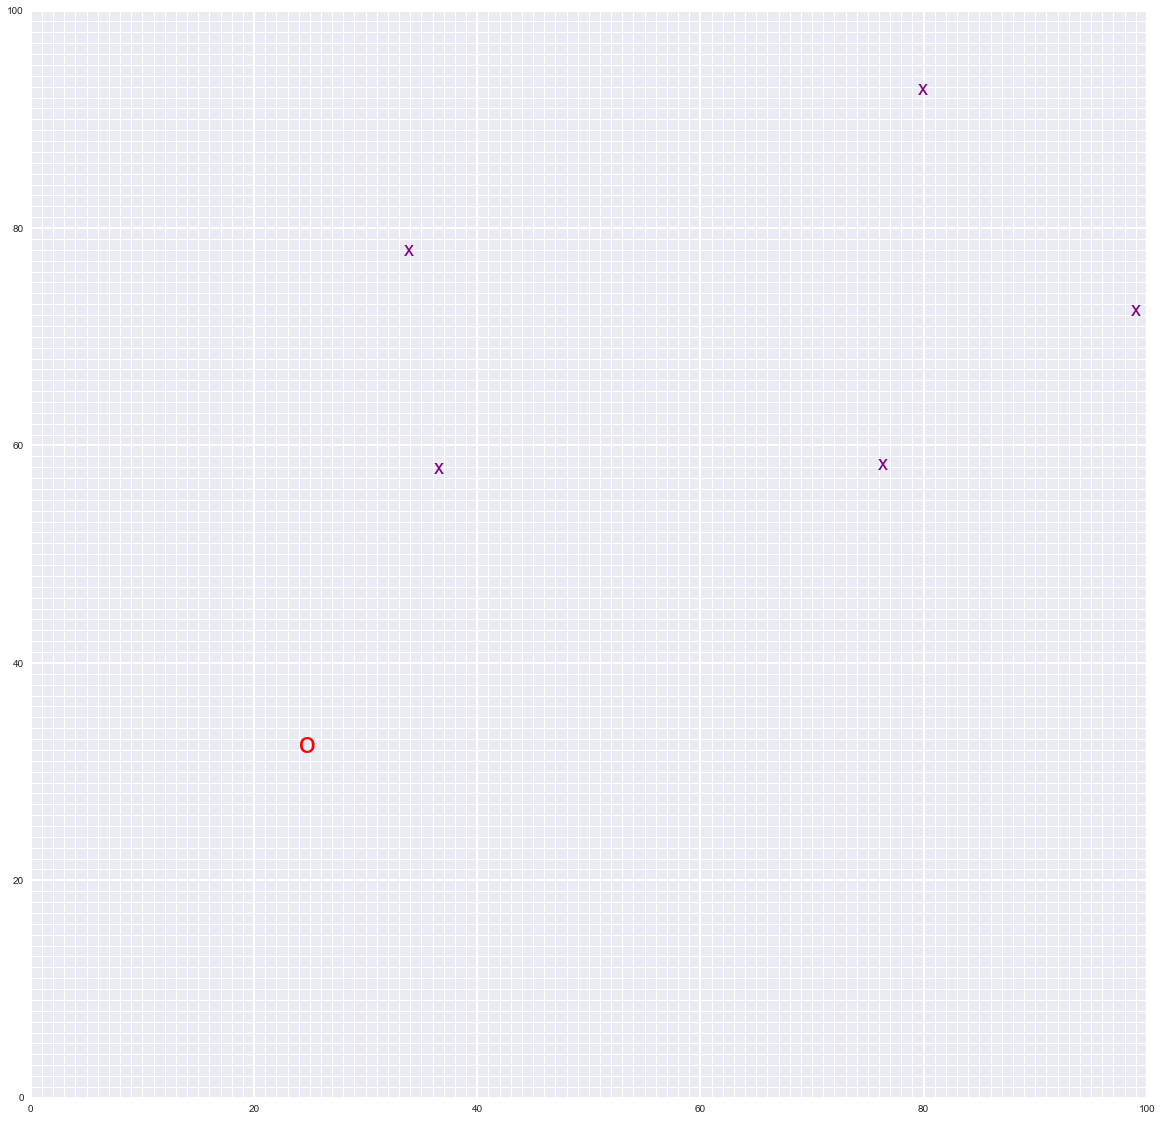

In [70]:
# import the helper function
from helper import display_world

# Display the final world!

# define figure size
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_grid), poses[-1], landmarks)

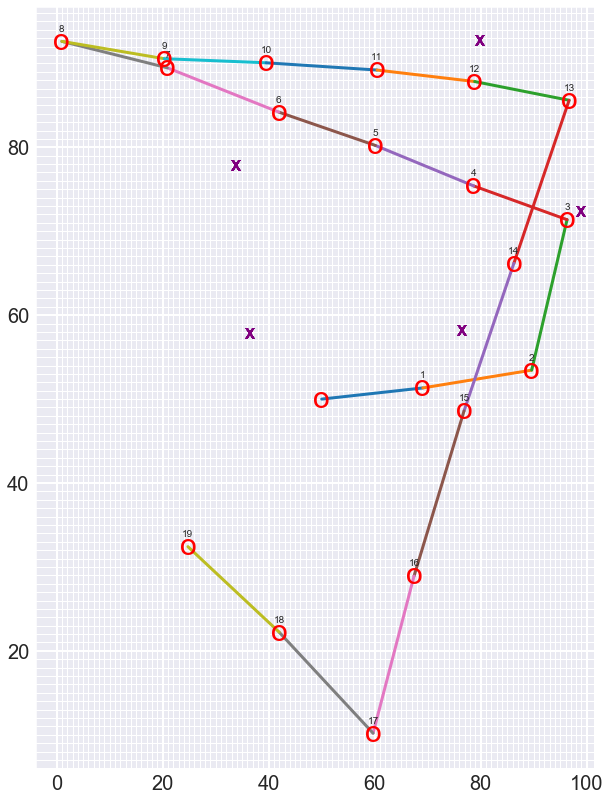

In [79]:
nx=0
ny=0
for i, pose in enumerate(poses):
    save_display_world(str(i), world_grid,[pose[0], pose[1]], landmarks, next_point = [nx, ny])
    nx, ny = pose[0], pose[1]

In [80]:
import cv2
import numpy as np
import glob
import re
 
img_array = []
each_image_duration = 10
filenames = [ filename for filename in glob.glob('/Users/mayurjain/Computer VIsion Nanodegree/Motion/2d movement/*.png')]
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))

for filename in filenames:
    img = cv2.imread(filename)
    #print(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    for _ in range(each_image_duration):
        out.write(img_array[i])
out.release()

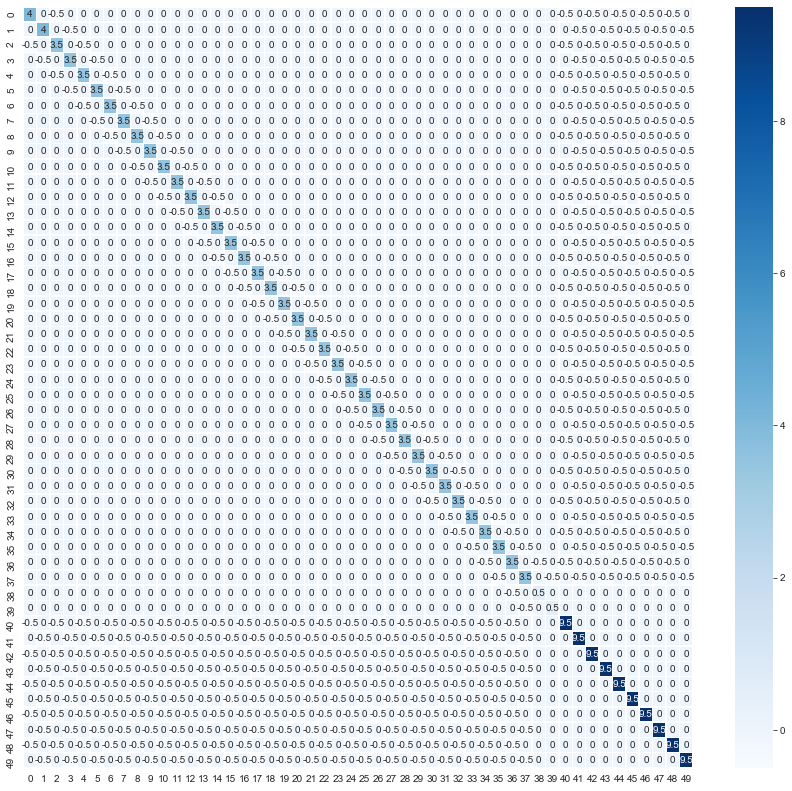

In [76]:
# define figure size
plt.rcParams["figure.figsize"] = (15,14)

# display omega
sns.heatmap(DataFrame(omega), cmap='Blues', annot=True, linewidths=.5)
plt.savefig("Omega.png")

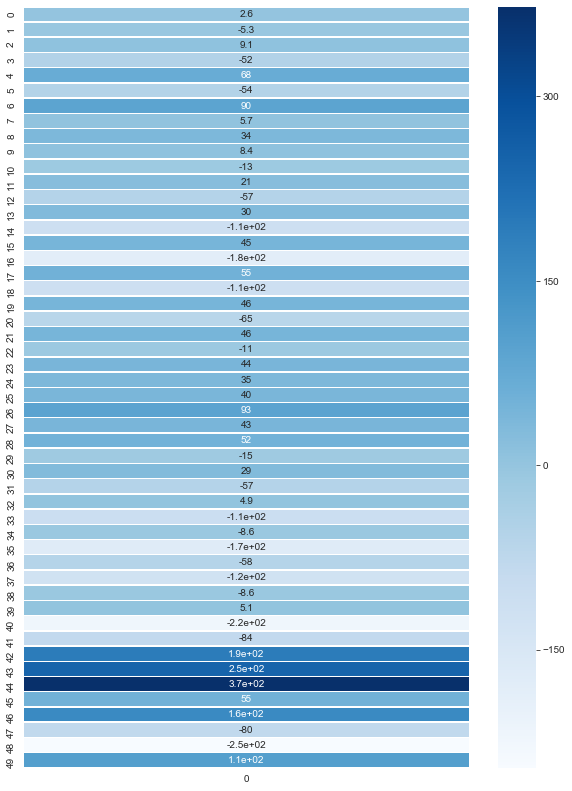

In [77]:
# define figure size
plt.rcParams["figure.figsize"] = (10,14)

# display omega
sns.heatmap(DataFrame(xi), cmap='Blues', annot=True, linewidths=.5)
plt.savefig('Xi.png')